# 07_A_Experiment_1_5

## This is the primary file to run and experiment around for Experiment 1. 
Files 07_B and 07_C are secondary scripts that were used to speed up computation and allow parallel coding. 

### Sources used 

We use the EvalHook and MyTrainer function explain in  https://eidos-ai.medium.com/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e and documented in  https://gist.github.com/ortegatron/c0dad15e49c2b74de8bb09a5615d9f6b to allow calculation of the validation loss. 
We adapt it using a hook addtion taken from https://www.kaggle.com/c/sartorius-cell-instance-segmentation/discussion/287023 to allow for model saving. 

We have further done abstractions on https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5 provided by the Detectron2 Team. 


In [1]:

!pip install pyyaml==5.1
#!pip uninstall torch
!yes | pip uninstall detectron2
#!pip install torch==1.9.0+cu102 torchvision==0.10.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
    
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Found existing installation: detectron2 0.6+cu111
Uninstalling detectron2-0.6+cu111:
  Would remove:
    /usr/local/lib/python3.8/dist-packages/detectron2-0.6+cu111.dist-info/*
    /usr/local/lib/python3.8/dist-packages/detectron2/*
    /usr/local/lib/python3.8/dist-packages/tools/*
Proceed (y/n)?   Successfully uninstalled detectron2-0.6+cu111
yes: standard output: Broken pipe
Looking in links: https://download.pytorch.org/whl/torch_stable.html
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html
  Using cached https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/detectron2-0.6%2Bcu111-cp38-cp38-linux_x86_64.whl (6.9 MB)


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [7]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
torch:  1.9 ; cuda:  cu111
detectron2: 0.6


In [8]:
#!pip install datetime

In [9]:
import os
import sys

In [10]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [11]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog

from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.data import build_detection_train_loader
from detectron2.data import DatasetMapper
from detectron2.data import DatasetCatalog

from detectron2.checkpoint import DetectionCheckpointer, PeriodicCheckpointer

from detectron2.config import get_cfg
from detectron2 import model_zoo

In [12]:
import json
from datetime import datetime

In [6]:
# Error Message while training: module 'distutils' has no attribute 'version'
#!python3 -m pip install setuptools==58.2.0
# then restart the kernel

In [13]:
## Function to register our datasets 
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog

dataset_name_train = "thesis_030_train"
dataset_name_val = "thesis_030_val"

def register(name, path_labels, path_data):

    # Check if dataset name already exists in catalog
    if name in DatasetCatalog.list():
        
        # Remove existing dataset from catalog
        DatasetCatalog.remove(name)
        MetadataCatalog.remove(name)

    # Register your dataset using register_coco_instances
    register_coco_instances(name, {}, path_labels, path_data)

# if it throws an error that name is already registered, just change the name... 
register(dataset_name_train, "/workspace/data/labels_train.json", "/workspace/data/data_030/train/data")
register(dataset_name_val, "/workspace/data/labels_val.json", "/workspace/data/data_030/val/data")

In [14]:
base_path = "/workspace/scripts"

os.chdir(base_path)

In [15]:
# Taken from https://eidos-ai.medium.com/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e
# https://gist.github.com/ortegatron/c0dad15e49c2b74de8bb09a5615d9f6b

from EvalLossHook import LossEvalHook
from detectron2.engine import BestCheckpointer
from detectron2.checkpoint import DetectionCheckpointer

class MyTrainer(DefaultTrainer):
        
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)
                     
    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(-1,LossEvalHook(
            self.cfg.TEST.EVAL_PERIOD,
            self.model,
            build_detection_test_loader(
                self.cfg,
                self.cfg.DATASETS.TEST[0],
                DatasetMapper(self.cfg,True)
            )
        ))
        
        # add the best checkpointer hook
        # adapted from https://www.kaggle.com/c/sartorius-cell-instance-segmentation/discussion/287023
        hooks.insert(-1, BestCheckpointer(self.cfg.TEST.EVAL_PERIOD, 
                                         DetectionCheckpointer(self.model, self.cfg.OUTPUT_DIR),
                                         "bbox/AP50",
                                         "max",
                                         "best_ap50"
                                         ))
        return hooks

    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg)
 


In [11]:
# put it all in a function to be able to build a loop for the different resolutions
from detectron2.checkpoint import DetectionCheckpointer, PeriodicCheckpointer


def train_detectron_standard(dataset_name_train, 
                             dataset_name_val, 
                             resolution,
                             iterations,
                             eval_period = None,
                             batch_size = 8,
                             anchors = [[4, 8, 16, 32, 64]],
                             weight_decay = 0.0001,
                             solver_steps_divider = 10,
                             freeze_at = 2
                            ):
    
    """
    Trains a Faster R-CNN object detection model using Detectron2 on the specified training and validation datasets.

    Args:
    - dataset_name_train (str): the name of the training dataset
    - dataset_name_val (str): the name of the validation dataset
    - resolution (int): the resolution of the input images in pixels (e.g., 640, 800, 1024)
    - iterations (int): the maximum number of iterations to train the model for
    - eval_period (int): the number of iterations between each evaluation of the validation dataset (default: None)
    - batch_size (int): the number of images per batch (default: 8)
    - anchors (list): a list of anchor sizes for the anchor generator (default: [[4, 8, 16, 32, 64]])
    - weight_decay (float): the weight decay coefficient (default: 0.0001)
    - solver_steps_divider (int): the number of solver steps to divide the total iterations into (default: 10)
    - freeze_at (int): the number of backbone stages to freeze during training (default: 2)

    Returns:
    - cfg (CfgNode): the configuration object used for training
    - trainer (MyTrainer): the trained model's trainer object
    - predictor (DefaultPredictor): a predictor object for the trained model
    """
        
    now = datetime.now() 
    output_dir = f"/workspace/output/output_new_res{resolution}_{now.strftime('%m.%d.%H.%M')}"


    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
    cfg.INPUT.FORMAT = "RGB"
    
    cfg.OUTPUT_DIR = output_dir
    cfg.DATASETS.TRAIN = (dataset_name_train)
    cfg.DATASETS.TEST = (dataset_name_val,)
    cfg.DATASETS.EVAL = (dataset_name_val,)

    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.ANCHOR_GENERATOR.SIZES = anchors
    cfg.SOLVER.MAX_ITER = iterations
    cfg.TEST.EVAL_PERIOD = eval_period # für unseren Evaluator

    cfg.SOLVER.IMS_PER_BATCH = batch_size
    cfg.SOLVER.WEIGHT_DECAY = weight_decay
    #cfg.SOLVER.STEPS = [i for i in range(0, iterations, round(iterations/solver_steps_divider))][1:]
    #print(cfg.SOLVER.STEPS)
    
    cfg.MODEL.BACKBONE.FREEZE_AT = freeze_at
    print("freeeeezeeeee:", cfg.MODEL.BACKBONE.FREEZE_AT)
    
      
    
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
    cfg.TEST.DETECTIONS_PER_IMAGE = 30

    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    
    trainer = MyTrainer(cfg)
    trainer.resume_or_load(resume=False)
    trainer.train()
    
    
    predictor = DefaultPredictor(cfg)
    
    return cfg, trainer, predictor

def evaluate_detectron(cfg, predictor_obj, resolution, dataset_name_val): 

    """
    func:   evaluates a trained detectron model

    input:
    cfg:                configuration object of the model
    predictor_obj:      the predictor object of the same model 
    resolution:         the resolution of the images
    dataset_name_val:   the COCO registered name of the val dataset

    returns:            dictionary with model metrics 
    """

    evaluator = COCOEvaluator(dataset_name_val, output_dir="/workspace/output/output"+str(resolution))
    val_loader = build_detection_test_loader(cfg, dataset_name_val)
    
    return inference_on_dataset(predictor_obj.model, val_loader, evaluator)

## Hyperparamter Tuning

In [16]:
def restructure_labels(labels_file, image_dir):
    with open(labels_file, 'r') as f:
        labels_data = json.load(f)

    file_data = []
    for img in labels_data['images']:
        file_name = img['file_name']
        img_id = img['id']
        height = img['height']
        width = img['width']
        img_path = image_dir + '/' + file_name

        annotations = []
        for anno in labels_data['annotations']:
            if anno['image_id'] == img_id:
                bbox = anno['bbox']
                bbox_mode = 0
                category_id = anno['category_id']
                annotations.append({
                    'bbox': bbox,
                    'bbox_mode': bbox_mode,
                    'category_id': category_id
                })

        file_data.append({
            'file_name': img_path,
            'height': height,
            'width': width,
            'image_id': img_id,
            'annotations': annotations
        })

        return file_data

In [17]:
#from detectron2.utils.comm import create_local_process_group # show the import here as reference 

def train_detectron_tune(config_dict = None, 
                         default_dict = None,
                         resolution = "res_missing",
                         output_dir_prefix = None,
                         trial_id = None,
                         dataset_name_train = '030_train',
                        dataset_name_val = '030_val'
                        ):
    
    """
    Trains a Detectron2 object detection model using the given configuration parameters, and returns the trained model
    as well as a predictor object for inference.

    Parameters:
        config_dict (dict): A dictionary of custom configuration parameters to override the default parameters.
        default_dict (dict): A dictionary of default configuration parameters to use when custom parameters are not provided.
        resolution (str): The resolution of the input images. Default is "res_missing".
        output_dir_prefix (str): A prefix to use when creating the output directory for the trained model. If not provided,
                                 the prefix will be "res{resolution}_{current_time}".
        trial_id (str): A unique identifier for this training run. This will be appended to the output directory name.
        dataset_name_train (str): The name of the training dataset.
        dataset_name_val (str): The name of the validation dataset.

    Returns:
        cfg (CfgNode): The configuration object used to train the model.
        trainer (MyTrainer): The trainer object used to train the model.
        predictor (DefaultPredictor): The predictor object used to perform inference with the trained model.
    """

    if config_dict is None:
        config_dict = {}
    if default_dict is None:
        default_dict = {
            'eval_period': None,
            'learning_rate': 0.001,
            'batch_size': 8,
            'anchors': [[4, 8, 16, 32, 64]],
            'weight_decay': 0.0001,
            'solver_steps_divider': 10,
            'freeze_at': 2,
            'gradient_clipping': False}

    # Merge default_dict with my_dict, overriding any duplicate keys
    config = {**default_dict, **config_dict}
    
    print(config)
    
    register(dataset_name_train, "/workspace/data/labels_tower_train.json", f"/workspace/data/data_{resolution}/train/data")
    register(dataset_name_val, "/workspace/data/labels_test_without_mexico.json", f"/workspace/data/data_{resolution}/test/data")
    
    if output_dir_prefix:
        now = datetime.now() 
        output_dir = f"/workspace/output/{output_dir_prefix}/res{resolution}_{trial_id}"
    else:
        now = datetime.now() 
        output_dir = f"/workspace/output/res{resolution}_{now.strftime('%m.%d.%H.%M')}"
        
    #create_local_process_group(num_workers_per_machine=2)
    
    # batchsize * iterations
    views = 120000
    
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
    cfg.INPUT.FORMAT = "RGB"
    
    cfg.OUTPUT_DIR = output_dir
    print(cfg.OUTPUT_DIR)
    cfg.DATASETS.TRAIN = (dataset_name_train)
    cfg.DATASETS.TEST = (dataset_name_val,)
    cfg.DATASETS.EVAL = (dataset_name_val,)

    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.ANCHOR_GENERATOR.SIZES = config['anchors']
    cfg.SOLVER.MAX_ITER = round(views/config['batch_size'])
    cfg.TEST.EVAL_PERIOD = cfg.SOLVER.MAX_ITER / 8 # für unseren Evaluator

    cfg.SOLVER.IMS_PER_BATCH = config['batch_size']
    cfg.SOLVER.BASE_LR = config['learning_rate']
    cfg.SOLVER.WEIGHT_DECAY = config['weight_decay']
    cfg.SOLVER.CLIP_GRADIENTS.ENABLED = config['gradient_clipping']
    cfg.SOLVER.STEPS = [.5*cfg.SOLVER.MAX_ITER, .75*cfg.SOLVER.MAX_ITER, .9*cfg.SOLVER.MAX_ITER]
    #print(cfg.SOLVER.STEPS)
    
    cfg.MODEL.BACKBONE.FREEZE_AT = config['freeze_at']
      
    
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
    cfg.TEST.DETECTIONS_PER_IMAGE = 30

    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    
    trainer = MyTrainer(cfg)
    trainer.resume_or_load(resume=False)
    trainer.train()
    
    
    predictor = DefaultPredictor(cfg)
    
    return cfg, trainer, predictor

In [18]:
import random as rd
import itertools


def get_combinations(d):
    keys = d.keys()
    values = d.values()
    combinations = list(itertools.product(*values))
    return [dict(zip(keys, c)) for c in combinations]

def load_json_arr(json_path):
    lines = []
    with open(json_path, 'r') as f:
        for line in f:
            lines.append(json.loads(line))
    return lines

def tune_bruteforce(search_space, max_trials = None):
    
    now = datetime.now() 
    unravelled_space = get_combinations(search_space)
    output_dir_prefix = f"hyper_tune_5_{now.strftime('%m.%d.%H.%M')}"
    
    # if there is no specification run a full grid search
    if max_trials != None:
        unravelled_space = rd.sample(unravelled_space, max_trials)
        
        
    print(f"Saving to: {output_dir_prefix}")
    print(f"Beginning to search in: {unravelled_space}")
    
    trial_dict = {}
    
    if not os.path.exists(f'/workspace/output/{output_dir_prefix}'):
        os.mkdir(f'/workspace/output/{output_dir_prefix}')
    
    ap50 = 0
    best_config = None
    
    
    for t, config in enumerate(unravelled_space):
        
        trial = {'config': config}
        
        try:
            cfg, trainer, predictor = train_detectron_tune(config, 
                             resolution = '030',
                            output_dir_prefix = output_dir_prefix,
                            dataset_name_train = '030_train',
                            dataset_name_val = '030_val',
                            trial_id = t)
        
        
            trial['metrics_path'] = cfg.OUTPUT_DIR
        
            metrics = load_json_arr(cfg.OUTPUT_DIR + '/metrics.json')
            trial['maxAP50'] = max([met["bbox/AP50"] for met in metrics if 'bbox/AP50' in met and 'validation_loss' in met])

            if trial['maxAP50'] > ap50:
                ap50 = trial['maxAP50']
                best_config = t
        except:
            trial['failed'] = True
        
        trial_dict[t] = trial 
        
    with open(f'/workspace/output/{output_dir_prefix}/results_tuning.json', 'w') as f:
        json.dump(trial_dict, f)
    
    return ap50, best_config, trial_dict
        

In [19]:
# output_tuning = tune_bruteforce(search_space = {
#         "learning_rate": [1/(10**i) for i in range(2,5)],
#         "batch_size": [5],
#         'gradient_clipping': [True, False],
#         'weight_decay': [1/(10**i) for i in range(3,5)],
#         'freeze_at': [1,2]
#     })

In [20]:
[1/(10**i) for i in range(3,5)]

[0.001, 0.0001]

In [21]:
import pandas as pd
res_5 = load_json_arr("../output/hyper_tune_5_04.05.14.09/results_tuning.json")
res_8 = load_json_arr("../output/hyper_tune_8_04.05.14.12/results_tuning.json")


res_5_df = pd.DataFrame.from_dict(res_5[0], orient='index')
res_5_df['index'] = [i for i in range(len(res_5_df))]
list_of_dicts = []
for j, i in enumerate(res_5_df['config']):
    i['index'] = j
    list_of_dicts.append(i)
    
res_5_df = pd.merge(res_5_df, pd.DataFrame(list_of_dicts), on = 'index')


res_8_df = pd.DataFrame.from_dict(res_8[0], orient='index')
res_8_df['index'] = [i for i in range(len(res_8_df))]
list_of_dicts = []
for j, i in enumerate(res_8_df['config']):
    i['index'] = j
    list_of_dicts.append(i)
    
res_8_df = pd.merge(res_8_df, pd.DataFrame(list_of_dicts), on = 'index')


hyper_df = pd.concat([res_5_df, res_8_df], ignore_index=True)

hyper_df.head()

,config,metrics_path,maxAP50,index,learning_rate,batch_size,gradient_clipping,weight_decay,freeze_at
0,"{'learning_rate': 0.01, 'batch_size': 5, 'grad...",/workspace/output/hyper_tune_5_04.05.14.09/res...,33.906152,0,0.01,5,True,0.0010,1
1,"{'learning_rate': 0.01, 'batch_size': 5, 'grad...",/workspace/output/hyper_tune_5_04.05.14.09/res...,34.950172,1,0.01,5,True,0.0010,2
2,"{'learning_rate': 0.01, 'batch_size': 5, 'grad...",/workspace/output/hyper_tune_5_04.05.14.09/res...,37.845422,2,0.01,5,True,0.0001,1
3,"{'learning_rate': 0.01, 'batch_size': 5, 'grad...",/workspace/output/hyper_tune_5_04.05.14.09/res...,30.968424,3,0.01,5,True,0.0001,2
4,"{'learning_rate': 0.01, 'batch_size': 5, 'grad...",/workspace/output/hyper_tune_5_04.05.14.09/res...,28.864825,4,0.01,5,False,0.0010,1


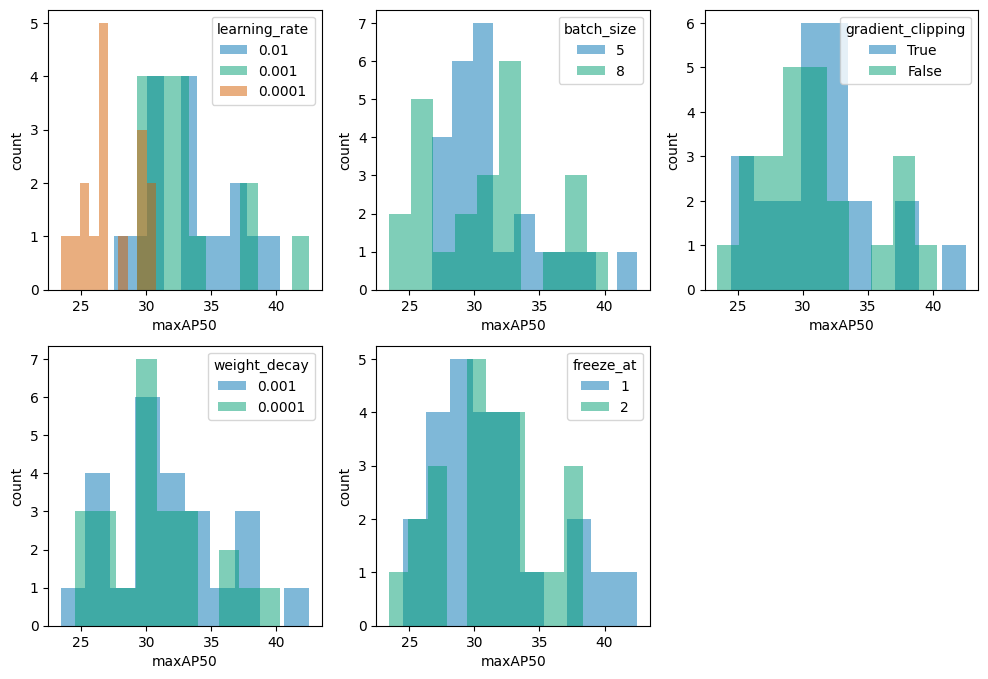

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12,8))
def plot_hist_by_param(df, param, sub_i):
    unique_vals = df[param].unique()
    plt.subplot(2,3, sub_i+1)
    for val in unique_vals:
        sub_df = df[df[param] == val]
        plt.hist(sub_df['maxAP50'], alpha=0.5, label=str(val))
    plt.legend(title=param)
    plt.xlabel('maxAP50')
    plt.ylabel('count')

    
for i, param in enumerate(['learning_rate', 'batch_size', 'gradient_clipping', 'weight_decay','freeze_at']):
    plot_hist_by_param(hyper_df, param, i)
plt.show()

In [32]:
import plotly.express as px

fig = px.parallel_coordinates(hyper_df, color="maxAP50",
                              dimensions=['learning_rate', 'batch_size', 'gradient_clipping', 'weight_decay','freeze_at'],
                              color_continuous_scale=px.colors.diverging.Tealrose,
                              color_continuous_midpoint=2)
fig.show()

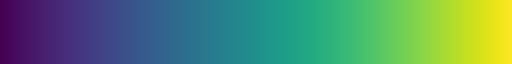

In [33]:
cmap = plt.get_cmap('viridis')
cmap

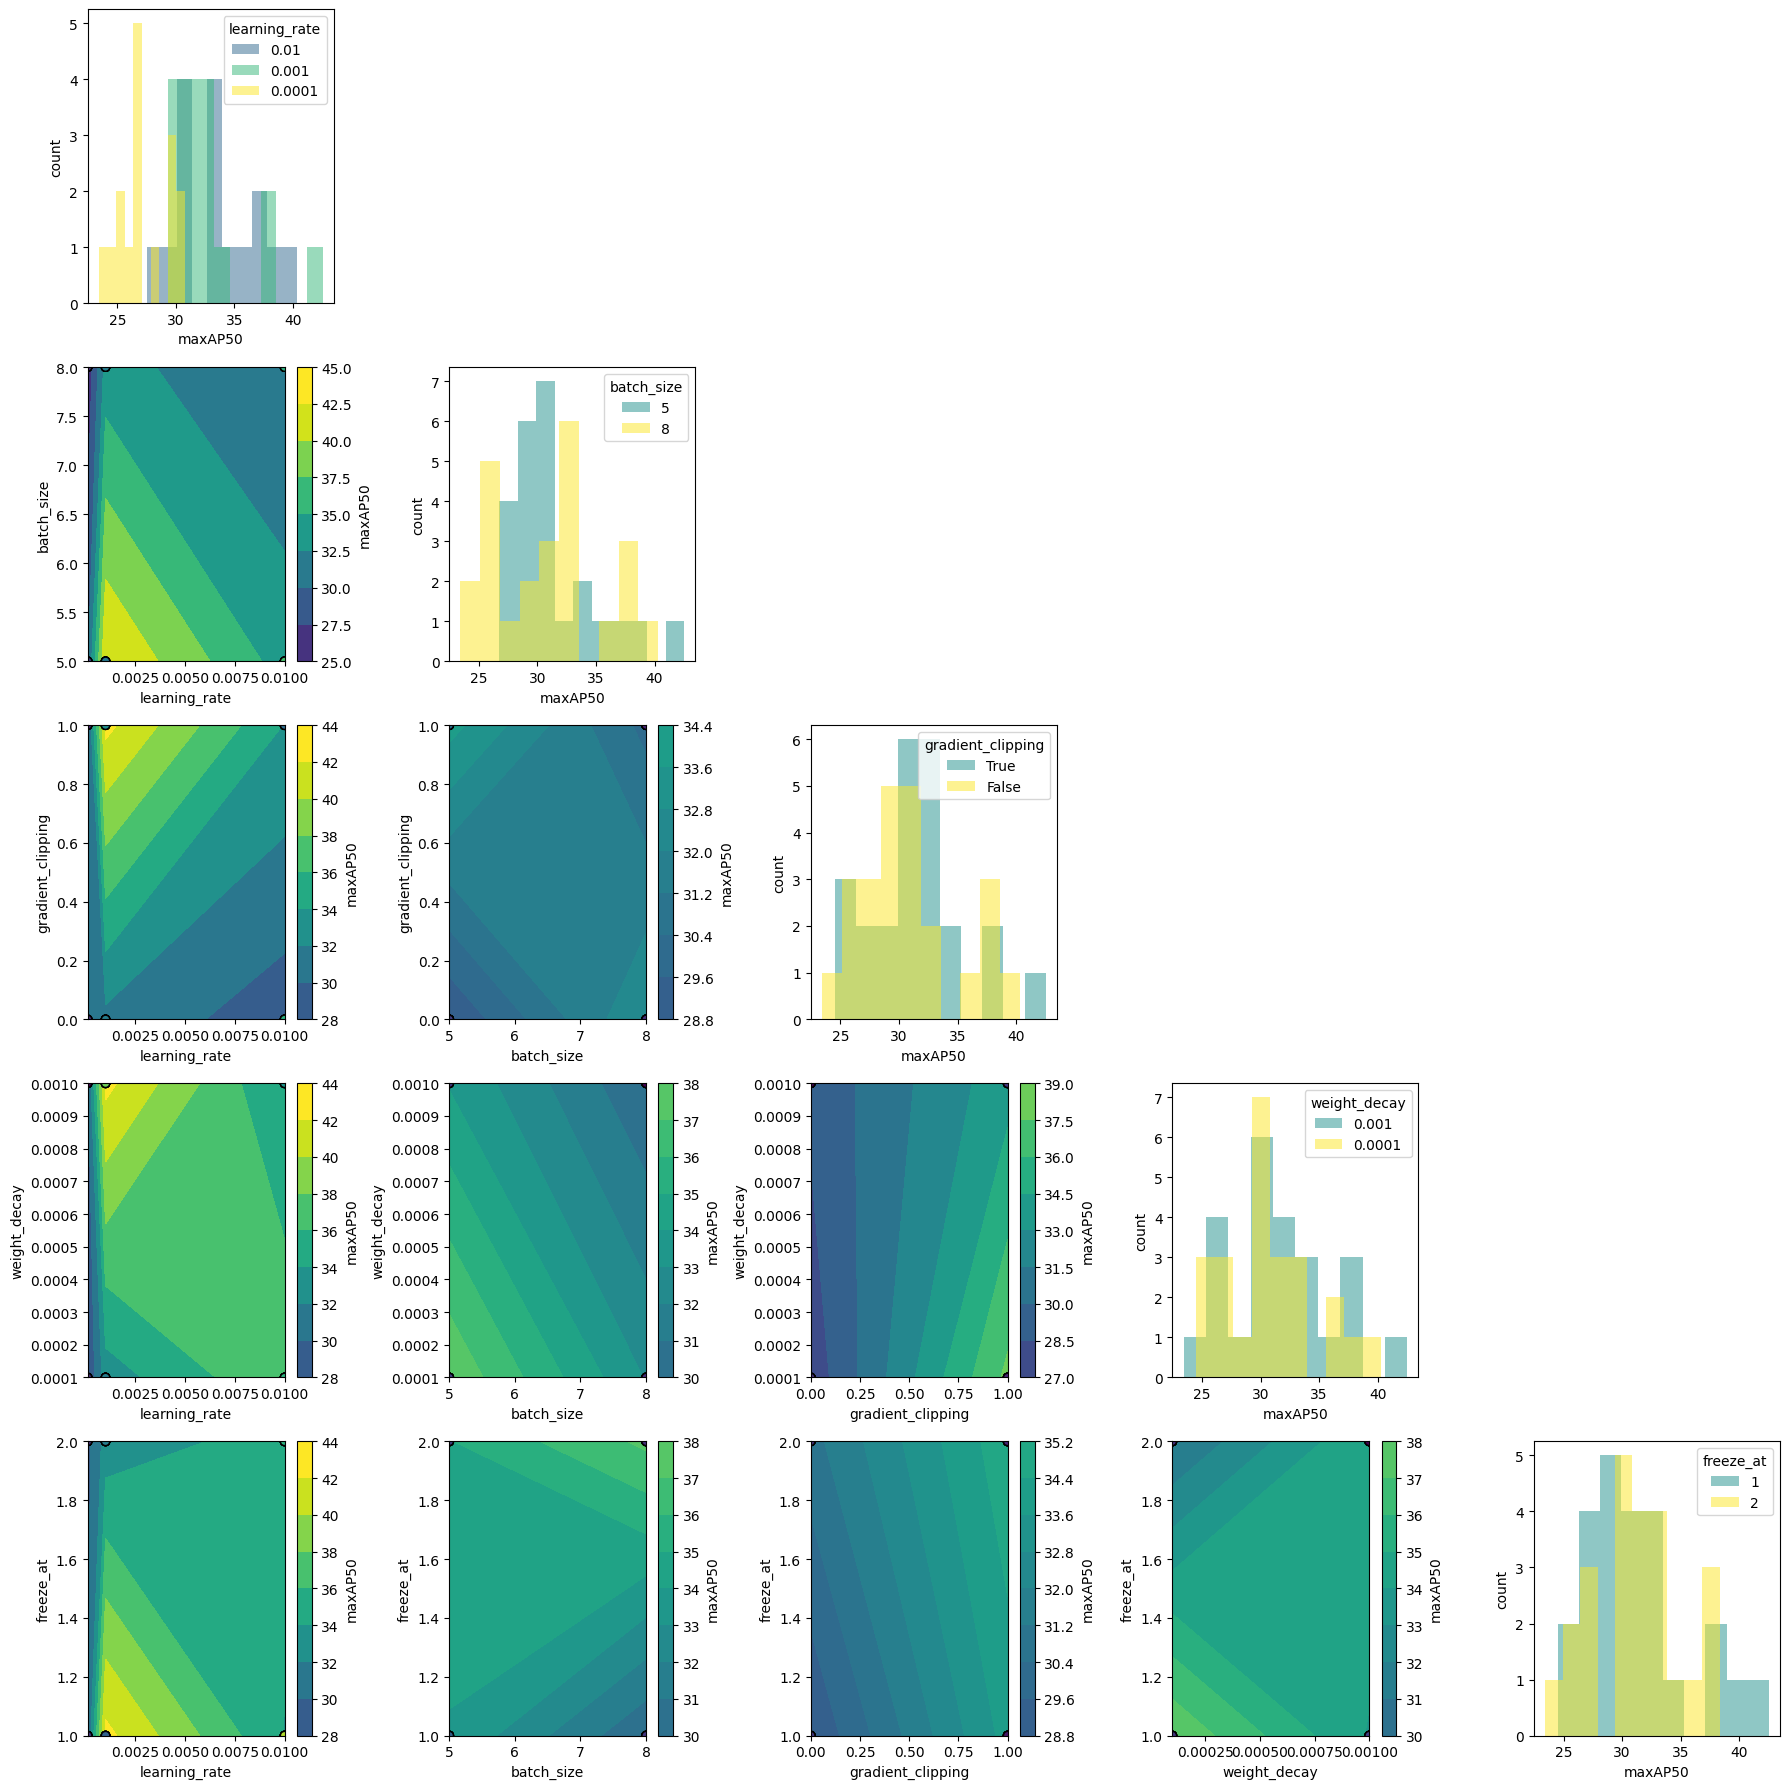

In [34]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np



def plot_contour_by_params(df, params):
    n_params = len(params)
    fig, axs = plt.subplots(nrows=n_params, ncols=n_params, figsize=(18, 18))
    plt.style.use('seaborn-v0_8-colorblind')

    # Set a common color scale for all plots
    vmin = df['maxAP50'].min()
    vmax = df['maxAP50'].max()
    
    combos = []
    
    cmap = plt.get_cmap('viridis')
    for j, x_param in enumerate(params):
        for i, y_param in enumerate(params):
            if i == j:
                
                # plot histogram grouped by parameters
                ax = axs[i, j]
                unique_vals = df[x_param].unique()
                for idx, val in enumerate(unique_vals):
                    sub_df = df[df[x_param] == val]
                    color = cmap((idx+1) / len(unique_vals))
                    ax.hist(sub_df['maxAP50'], alpha=0.5, label=str(val), color = color)
                ax.legend(title=x_param)
                ax.set_xlabel('maxAP50')
                ax.set_ylabel('count')
                
                continue
            if (y_param, x_param) in combos:
                axs[i, j].remove()
                continue
            
            combos.append((x_param, y_param))
            
            # Get unique values of x_param and y_param
            x_vals = df[x_param].unique()
            y_vals = df[y_param].unique()
            
            # Create a grid of x and y parameter values
            xx, yy = np.meshgrid(x_vals, y_vals, indexing='ij')
            zz = np.zeros((len(x_vals), len(y_vals)))
            
            # Fill in values of maxAP50 for each combination of x_param and y_param
            for k, x_val in enumerate(x_vals):
                for l, y_val in enumerate(y_vals):
                    sub_df = df[(df[x_param] == x_val) & (df[y_param] == y_val)]
                    zz[k, l] = sub_df['maxAP50'].values[0] if len(sub_df) > 0 else np.nan
            
            # Plot the contour
            ax = axs[i, j]
            cs = ax.contourf(xx, yy, zz, vmin=vmin, vmax=vmax)
            ax.set_xlabel(x_param)
            ax.set_ylabel(y_param)

            # Add color scale
            cbar = fig.colorbar(cs, ax=ax)
            cbar.ax.set_ylabel('maxAP50')

            # Add individual data points
            ax.scatter(df[x_param], df[y_param], c=df['maxAP50'], vmin=vmin, vmax=vmax, cmap='viridis', edgecolor='black')
    
    plt.tight_layout()
    
    plt.savefig('/workspace/figures/hyperparameter_tuning', pad_inches = 0, bbox_inches = 0)
    plt.show()

params = ['learning_rate', 'batch_size', 'gradient_clipping', 'weight_decay', 'freeze_at']
plot_contour_by_params(hyper_df, params)

In [22]:
hyper_df.sort_values(by=['maxAP50'], ascending = False)

best_settings =hyper_df.sort_values(by=['maxAP50'], ascending = False)['config'].values[:3]

In [23]:
best_settings

array([{'learning_rate': 0.001, 'batch_size': 5, 'gradient_clipping': True, 'weight_decay': 0.001, 'freeze_at': 1, 'index': 8},
       {'learning_rate': 0.01, 'batch_size': 8, 'gradient_clipping': False, 'weight_decay': 0.0001, 'freeze_at': 1, 'index': 6},
       {'learning_rate': 0.001, 'batch_size': 8, 'gradient_clipping': False, 'weight_decay': 0.001, 'freeze_at': 2, 'index': 13}],
      dtype=object)

In [20]:
for i in best_settings:
    print(i)

{'learning_rate': 0.001, 'batch_size': 5, 'gradient_clipping': True, 'weight_decay': 0.001, 'freeze_at': 1, 'index': 8}
{'learning_rate': 0.01, 'batch_size': 8, 'gradient_clipping': False, 'weight_decay': 0.0001, 'freeze_at': 1, 'index': 6}
{'learning_rate': 0.001, 'batch_size': 8, 'gradient_clipping': False, 'weight_decay': 0.001, 'freeze_at': 2, 'index': 13}


## Test on Resolution

In [ ]:
# train the model for all our resolutions on a given config setting 

best_config = {'learning_rate': 0.001, 
              'batch_size': 8, 
              'gradient_clipping': False, 
              'weight_decay': 0.001, 
              'freeze_at': 2}


for best_config in best_settings:

    resolution_set = ['300','1000']

    now = datetime.now() 
    output_dir_prefix = 'experiment1_test_bestconf_3001000'
    if not os.path.exists(f'/workspace/output/{output_dir_prefix}'):
        os.mkdir(f'/workspace/output/{output_dir_prefix}')


    ap50 = 0
    highest_config = None    
    trial_dict = {}


    print(f"Saving to: {output_dir_prefix}")


    for res in resolution_set:

        # define the names 
        dataset_name_train = "tower_train_" + str(res)
        dataset_name_val = "tower_val_" + str(res)


        trial = {'config': best_config}

        try:
            cfg, trainer, predictor = train_detectron_tune(best_config, 
                             resolution = res,
                            output_dir_prefix = output_dir_prefix,
                            dataset_name_train = dataset_name_train,
                            dataset_name_val = dataset_name_val,
                            trial_id = int(res))


            trial['metrics_path'] = cfg.OUTPUT_DIR

            metrics = load_json_arr(cfg.OUTPUT_DIR + '/metrics.json')
            trial['maxAP50'] = max([met["bbox/AP50"] for met in metrics if 'bbox/AP50' in met and 'validation_loss' in met])

            if trial['maxAP50'] > ap50:
                ap50 = trial['maxAP50']
                highest_config = int(res)
        except:
            trial['failed'] = True

        trial_dict[res] = trial 

    with open(f'/workspace/output/{output_dir_prefix}/results_tuning.json', 'w') as f:
        json.dump(trial_dict, f)
    print(ap50, highest_config)

Saving to: experiment1_test_bestconf_3001000
{'eval_period': None, 'learning_rate': 0.001, 'batch_size': 5, 'anchors': [[4, 8, 16, 32, 64]], 'weight_decay': 0.001, 'solver_steps_divider': 10, 'freeze_at': 1, 'gradient_clipping': True, 'index': 8}
/workspace/output/experiment1_test_bestconf_3001000/res300_300
[04/27 08:18:47 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), str

WARNING [04/27 08:18:47 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/27 08:18:47 d2.data.datasets.coco]: Loaded 11696 images in COCO format from /workspace/data/labels_tower_train.json
[04/27 08:18:47 d2.data.build]: Removed 0 images with no usable annotations. 11696 images left.
[04/27 08:18:48 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   tower    | 55162        |
|            |              |
[04/27 08:18:48 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/27 08:18:48 d2.data.build]: Using training sampler TrainingSampler
[04/27 08:18:48 d2.data.common]: Serializing 11696 elements to byte tensors and concatenating them all ...
[04/27 08:18:48 d2.data.common]: Serialized dataset ta

[04/27 08:18:49 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[04/27 08:18:49 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up:
| Names in Model    | Names in Checkpoint       | Shapes                                          |
|:------------------|:--------------------------|:------------------------------------------------|
| res2.0.conv1.*    | res2_0_branch2a_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| res2.0.conv2.*    | res2_0_branch2b_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.0.conv3.*    | res2_0_branch2c_{bn_*,w}  | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.0.shortcut.* | res2_0_branch1_{bn_*,w}   | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.1.conv1.*    | res2_1_branch2a_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,256,1,1)            |
| res2.1.conv2.*    | res2_1_branch2b_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.1.c

Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
The checkpoint state_dict contains keys that are not used by the model:
  fc1000.{bias, weight}


[04/27 08:18:50 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.8/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[04/27 08:18:56 d2.utils.events]:  eta: 1:53:24  iter: 19  total_loss: 1.545  loss_cls: 0.7279  loss_box_reg: 0.00203  loss_rpn_cls: 0.684  loss_rpn_loc: 0.09749  time: 0.2689  data_time: 0.0377  lr: 1.9981e-05  max_mem: 5754M
[04/27 08:19:01 d2.utils.events]:  eta: 1:53:22  iter: 39  total_loss: 0.8667  loss_cls: 0.05254  loss_box_reg: 0.001077  loss_rpn_cls: 0.6761  loss_rpn_loc: 0.1096  time: 0.2710  data_time: 0.0254  lr: 3.9961e-05  max_mem: 5754M
[04/27 08:19:07 d2.utils.events]:  eta: 1:53:07  iter: 59  total_loss: 0.8153  loss_cls: 0.06197  loss_box_reg: 0.002307  loss_rpn_cls: 0.6588  loss_rpn_loc: 0.08178  time: 0.2733  data_time: 0.0259  lr: 5.9941e-05  max_mem: 5754M
[04/27 08:19:09 d2.engine.hooks]: Overall training speed: 65 iterations in 0:00:17 (0.2730 s / it)
[04/27 08:19:09 d2.engine.hooks]: Total training time: 0:00:17 (0:00:00 on hooks)
[04/27 08:19:09 d2.utils.events]:  eta: 1:53:01  iter: 67  total_loss: 0.8061  loss_cls: 0.06263  loss_box_reg: 0.00298  loss_rpn_c

WARNING [04/27 08:19:10 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/27 08:19:10 d2.data.datasets.coco]: Loaded 11696 images in COCO format from /workspace/data/labels_tower_train.json
[04/27 08:19:10 d2.data.build]: Removed 0 images with no usable annotations. 11696 images left.
[04/27 08:19:10 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/27 08:19:10 d2.data.build]: Using training sampler TrainingSampler
[04/27 08:19:10 d2.data.common]: Serializing 11696 elements to byte tensors and concatenating them all ...
[04/27 08:19:10 d2.data.common]: Serialized dataset takes 5.86 MiB
[04/27 08:19:10 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='c

[04/27 08:19:11 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[04/27 08:19:11 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up:
| Names in Model    | Names in Checkpoint       | Shapes                                          |
|:------------------|:--------------------------|:------------------------------------------------|
| res2.0.conv1.*    | res2_0_branch2a_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| res2.0.conv2.*    | res2_0_branch2b_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.0.conv3.*    | res2_0_branch2c_{bn_*,w}  | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.0.shortcut.* | res2_0_branch1_{bn_*,w}   | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.1.conv1.*    | res2_1_branch2a_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,256,1,1)            |
| res2.1.conv2.*    | res2_1_branch2b_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.1.c

Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
The checkpoint state_dict contains keys that are not used by the model:
  fc1000.{bias, weight}


[04/27 08:19:11 d2.engine.train_loop]: Starting training from iteration 0
ERROR [04/27 08:19:11 d2.engine.train_loop]: Exception during training:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/detectron2/engine/train_loop.py", line 149, in train
    self.run_step()
  File "/usr/local/lib/python3.8/dist-packages/detectron2/engine/defaults.py", line 494, in run_step
    self._trainer.run_step()
  File "/usr/local/lib/python3.8/dist-packages/detectron2/engine/train_loop.py", line 267, in run_step
    data = next(self._data_loader_iter)
  File "/usr/local/lib/python3.8/dist-packages/detectron2/data/common.py", line 234, in __iter__
    for d in self.dataset:
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 521, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1183, in _next_data
    return self._process_data(data)
  File "/usr/local/lib/python3

WARNING [04/27 08:19:12 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/27 08:19:12 d2.data.datasets.coco]: Loaded 11696 images in COCO format from /workspace/data/labels_tower_train.json
[04/27 08:19:12 d2.data.build]: Removed 0 images with no usable annotations. 11696 images left.
[04/27 08:19:13 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[04/27 08:19:13 d2.data.build]: Using training sampler TrainingSampler
[04/27 08:19:13 d2.data.common]: Serializing 11696 elements to byte tensors and concatenating them all ...
[04/27 08:19:13 d2.data.common]: Serialized dataset takes 5.84 MiB
[04/27 08:19:13 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='c

[04/27 08:19:13 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......
[04/27 08:19:13 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up:
| Names in Model    | Names in Checkpoint       | Shapes                                          |
|:------------------|:--------------------------|:------------------------------------------------|
| res2.0.conv1.*    | res2_0_branch2a_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| res2.0.conv2.*    | res2_0_branch2b_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.0.conv3.*    | res2_0_branch2c_{bn_*,w}  | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.0.shortcut.* | res2_0_branch1_{bn_*,w}   | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.1.conv1.*    | res2_1_branch2a_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,256,1,1)            |
| res2.1.conv2.*    | res2_1_branch2b_{bn_*,w}  | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.1.c

Some model parameters or buffers are not found in the checkpoint:
backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
The checkpoint state_dict contains keys that are not used by the model:
  fc1000.{bias, weight}


[04/27 08:19:13 d2.engine.train_loop]: Starting training from iteration 0
[04/27 08:19:22 d2.utils.events]:  eta: 1:51:13  iter: 19  total_loss: 0.9598  loss_cls: 0.07984  loss_box_reg: 0.001401  loss_rpn_cls: 0.6906  loss_rpn_loc: 0.1424  time: 0.4384  data_time: 0.0639  lr: 0.00019981  max_mem: 8793M


In [35]:
## WE TRIED HYPERPARAMTER TUNING WITH RAY BUT COULD NOT MAKE IT COOPERATE WITH OUR DATA REGISTRATION.

# import ray
# from ray import tune
# from ray.air import session
# from ray.air.checkpoint import Checkpoint
# from ray.tune.schedulers import ASHAScheduler

# # dataset_name_train = "thesis_030_train"
# # dataset_name_val = "thesis_030_val"
    
# # register(dataset_name_train, "/workspace/data/labels_train_DT.json", "/workspace/data/data_030/train/data")
# # register(dataset_name_val, "/workspace/data/labels_val_DT.json", "/workspace/data/data_030/val/data")
  

# def tuning_ray(metric = "bbox/AP50", num_samples = 4):
    

#     # Set up search space for hyperparameters
#     config = {
#         'dataset_name_train': '030_train',
#         'dataset_name_val': '030_val',
#         'iterations': tune.choice([80, 120]),
#         "batch_size": tune.choice([4, 8])
#         #,"weight_decay": tune.loguniform(1e-6, 1e-3)
#         # Add any other hyperparameters to be tuned here
#     }
    
#     print(config)

    
#     scheduler = ASHAScheduler(
#         max_t=10,
#         grace_period=1,
#         reduction_factor=2)
    
#     tuner = tune.Tuner(
#         tune.with_resources(
#             tune.with_parameters(train_detectron_tune,
#                                  resolution = '030'),
#             resources={"gpu": 1}
#         ),
#         tune_config=tune.TuneConfig(
#             metric=metric,
#             mode='max',
#             scheduler=scheduler,
#             num_samples=num_samples,
#         ),
#         param_space=config,
#     )
    
#     results = tuner.fit()

    
#     best_trial = results.get_best_trial(metric, "max", "last")
#     #print("Best trial config: {}".format(best_trial.config))
#     print("Best trial on{}: {}".format(metric, best_trial.last_result[metric]))

#     return results

In [34]:
# tuning_ray(num_samples = 5)

In [ ]:
### We also tried AX and could not get it to work

# #from ax.plot.contour import plot_contour
# #from ax.plot.trace import optimization_trace_single_method
# from ax.service.managed_loop import optimize
# from ax.utils.notebook.plotting import render, init_notebook_plotting


# def tune_ax(config):
    
#     cfg, trainer, predictor = train_detectron_tune(config)
    
#     return evaluate_detectron(cfg, 
#                               predictor_obj, 
#                               config['resolution'], 
#                               config['dataset_name_val'])
                                                                     
# best_parameters, values, experiment, model = optimize(
#     parameters=[
#         {"name": "batchsize", "type": "choice", "values": [4,8]}
#     ],
#     evaluation_function=tune_ax,
#     objective_name='bbox/AP50',
# )


## visualize predictions

In [ ]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import ColorMode

import random
import cv2
import matplotlib.pyplot as plt

def plot_sample(dataset_name, n=1):
    
    """
    Plots a random sample of images and annotations from a Detectron2 dataset.

    Args:
    - dataset_name (str): the name of the dataset registered with Detectron2.
    - n (int): the number of images to plot. Default is 1.

    Returns:
    - None
    """
    
    dataset_custom = DatasetCatalog.get(dataset_name)
    dataset_custom_metadata = MetadataCatalog.get(dataset_name)
    image_filepaths = random.sample(dataset_custom, n)
    for s in image_filepaths:
        
        img = cv2.imread(s["file_name"])
        v = Visualizer(img[:, :, ::-1], metadata=dataset_custom_metadata, scale=0.5)
        v = v.draw_dataset_dict(s)
        plt.figure(figsize=(12,12))
        plt.imshow(v.get_image())
        return plt.show()
    
    
def plot_prediction(dataset_name, predictor, n=1):
    
    """
    Plots a random image from a Detectron2 dataset and its corresponding predictions generated by the provided predictor.

    Args:
    - dataset_name (str): the name of the dataset registered with Detectron2.
    - predictor: a Detectron2 predictor object that takes an image as input and generates predictions.
    - n (int): the number of images to plot. Default is 1.

    Returns:
    - None
    """
    
    dataset_custom = DatasetCatalog.get(dataset_name)
    dataset_custom_metadata = MetadataCatalog.get(dataset_name)
    image_filepaths = random.sample(dataset_custom, n)
    print(len(image_filepaths))
    
    for s in image_filepaths: 
        im = cv2.imread(s["file_name"])
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 12))
        
        
        v = Visualizer(im[:, :, ::-1], metadata=dataset_custom_metadata, scale=0.5)
        v = v.draw_dataset_dict(s)
        ax[0].imshow(v.get_image())
        ax[0].axis('off')
        ax[0].set_title('Original Image')     
        
        
        outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
        v = Visualizer(im,#[:, :, ::-1],
                       metadata= MetadataCatalog.get(dataset_name), 
                       scale=0.5 
                       #,instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
        )
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        
        ax[1].imshow(out.get_image()[:, :, ::-1])
        ax[1].axis('off')
        ax[1].set_title('Predicted Image')

    return plt.show()
    

In [ ]:
plot_prediction(dataset_name_train, predictor_obj, 5)

## Removing Mexico

This creates a labels file without Mexico. It was used to create the labels file you use above.

In [19]:
with open('/workspace/data/labels_test_DT.json', 'r') as f:
    test_labels = json.load(f)

In [21]:
merged_dict = {"images": [], "annotations": []}
merged_dict['categories'] = [{"id": 0, "name": "DT", "supercategory": None}]
merged_dict["info"] = {"year": "", "version": "", "description": "", "contributor": "", "url": "https://voxel51.com/fiftyone", "date_created": "2023-03-13T16:25:21"} 
merged_dict["licenses"] = [],

country_dict = test_labels
country_images = [im for im in country_dict["images"] if im['file_name'][:2] != "ME"]
country_image_ids = [img["id"] for img in country_images]
country_annotations = [ann for ann in country_dict["annotations"] if ann["image_id"] in country_image_ids]

merged_dict["images"].extend(country_images)
merged_dict["annotations"].extend(country_annotations)



    #merged_dict["images"].extend(eval(dict_name)["images"])
    #merged_dict["annotations"].extend(eval(dict_name)["annotations"])

filename = 'labels_test_without_mexico.json'
with open(f'/workspace/data/{filename}', "w") as f:
    json.dump(merged_dict, f)
    